# Laboratorio 3 Data Science S10
- Arturo Argueta
- Astrid Glauser


In [1]:
import pandas as pd

In [2]:
# Carga de los conjutos de prueba y testing para ambos archivos
# Identicos al laboratorio Anterior

importacion_df = pd.read_excel('importacion.xlsx', skiprows=6)
importacion_df.columns = [
    'Fecha', 'AceitesLubricantes', 'Asfalto', 'Bunker', 'Ceras', 
    'CombustibleTurboJet', 'DieselLS', 'DieselUltraLS', 'GasLicuado', 
    'GasolinaAviacion', 'GasolinaRegular', 'GasolinaSuper', 'Kerosina', 
    'MTBE', 'Naftas', 'Petcoke', 'PetroleoCrudo', 'Solventes', 
    'Butano', 'DieselAltoAzufre', 'Orimulsion', 'PetroleoReconstituido', 
    'TotalImportacion', 'ColumnaExtra1', 'ColumnaExtra2'
]

# Convertir la columna de fechas a formato datetime
importacion_df['Fecha'] = pd.to_datetime(importacion_df['Fecha'], errors='coerce')
importacion_df = importacion_df.dropna()

#usar solo las columnas de interés ( 'GasolinaRegular', 'GasolinaSuper', 'DieselLS ,'DieselUltraLS', 'GasLicuado' y la Fecha)
importacion_df = importacion_df[['Fecha','GasolinaRegular', 'GasolinaSuper', 'DieselLS' ,'DieselUltraLS', 'GasLicuado']]
importacion_df.head()
importacion_df.describe()


,Fecha,GasolinaRegular,GasolinaSuper,DieselLS,DieselUltraLS,GasLicuado
count,280,280.000000,2.800000e+02,2.800000e+02,280.000000,2.800000e+02
mean,2012-08-17 11:24:00,399997.911549,4.848434e+05,3.099915e+05,2859.782429,4.080441e+05
min,2001-01-01 00:00:00,81015.300000,1.702925e+05,0.000000e+00,0.000000,1.005615e+05
25%,2006-10-24 06:00:00,204839.193690,3.665792e+05,0.000000e+00,0.000000,2.241630e+05
50%,2012-08-16 12:00:00,319948.200000,4.689286e+05,0.000000e+00,0.000000,4.095000e+05
75%,2018-06-08 12:00:00,548103.295000,5.932063e+05,7.914933e+05,0.000000,5.625798e+05
max,2024-05-01 00:00:00,987872.050000,1.227174e+06,1.592580e+06,48945.910000,1.077123e+06
std,NaN,233337.213857,1.540124e+05,5.217152e+05,8730.814372,1.968704e+05


In [3]:
#Separar en Train y Test usando esta fecha:
split_date = '2021-01-01'
print(importacion_df.shape)
#calcular el index para separar al normalizar los valores:
split_index = importacion_df[importacion_df['Fecha'] == split_date].index.tolist()[0]
split_index

(280, 6)


240

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import keras

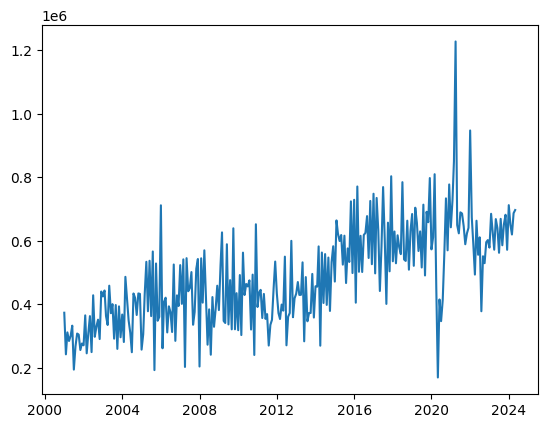

In [5]:
# Prediccion de la gasolina super
super_gas_df = importacion_df[['Fecha','GasolinaSuper']]
super_gas_df = super_gas_df.set_index('Fecha')
plt.plot(super_gas_df)

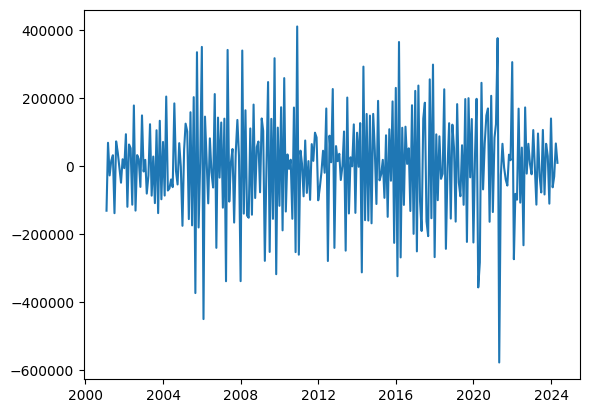

In [6]:
super_gas_diff = super_gas_df.diff()
plt.plot(super_gas_diff)

In [7]:
# normalizar los datos para el LSTM
scaler = StandardScaler()
super_gas_scaled = scaler.fit_transform(super_gas_diff) 
split_index = round(0.6*len(super_gas_scaled))
val_prueba = round(0.2*len(super_gas_scaled))
#separar en test y prueba
super_gas_train = super_gas_scaled[1:split_index]
super_gas_val = super_gas_scaled[split_index:val_prueba + split_index + 1]
super_gas_test = super_gas_scaled[(split_index+val_prueba)-1:]

In [8]:
#transformar la serie en una supervisada, de manera que las observaciones anteriores sean capaces de estimar la siguiente
from operator import concat
def supervisada(serie,retrasos = 1):
    serie_x = []
    serie_y = []
    for i in range(len(serie)-retrasos):
        valor = serie[i:(i+retrasos),0]
        valor_sig = serie[i+retrasos,0]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)

super_gas_x_train,super_gas_y_train = supervisada(super_gas_train)
super_gas_x_val,super_gas_y_val = supervisada(super_gas_val)
super_gas_test_x_test,super_gas_test_y_test = supervisada(super_gas_test)
print(super_gas_y_train[0:4])
print(super_gas_x_train[0:4])
#convertir en arreglos tridimensionales donde cada una es "muestras", "tiempo", "features"
super_gas_x_train = np.reshape(super_gas_x_train,(super_gas_x_train.shape[0],1,1))
super_gas_x_val = np.reshape(super_gas_x_val,(super_gas_x_val.shape[0],1,1))
super_gas_test_x_test = np.reshape(super_gas_test_x_test, (super_gas_test_x_test.shape[0],1,1))

[ 0.42584933 -0.17695003  0.09228833  0.19552297]
[[-0.82884453]
 [ 0.42584933]
 [-0.17695003]
 [ 0.09228833]]


In [8]:
lote = 1
unidades =  1
paso = 1
caracteristicas = 1 #es univariada

inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(lote)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

modelo1 = keras.Model(inputs=inputs, outputs=outputs)
modelo1.summary()
modelo1.compile(loss='mean_squared_error',optimizer="rmsprop")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm (LSTM)                 (None, 1)                 12        
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
inputs = keras.layers.Input((paso,caracteristicas))
lstm_out = keras.layers.LSTM(10)(inputs)
outputs = keras.layers.Dense(2)(lstm_out)

modelo2 = keras.Model(inputs=inputs, outputs=outputs)
modelo2.summary()
modelo2.compile(loss='mean_squared_error',optimizer="rmsprop")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 502 (1.96 KB)
Trainable params: 502 (1.96 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
epocas = 50
history= modelo1.fit(
    x = super_gas_x_train,
    y = super_gas_y_train,
    validation_data = (super_gas_x_val,super_gas_y_val),
    batch_size = lote,
    epochs = epocas,
    shuffle = False,
    verbose=1
)

Epoch 1/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5341
Epoch 2/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5049
Epoch 3/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4817
Epoch 4/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4640
Epoch 5/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4513
Epoch 6/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4427
Epoch 7/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 0.4370
Epoch 8/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4334
Epoch 9/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4312
Epoch 10/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4299
Epoch 11/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4290
Epoch 12/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4284
Epoch 13/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 0.4279
Epoch 14/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 0.4275
Epoch 15/50
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/ste

In [11]:
epocas = 50
history2= modelo2.fit(
    x = super_gas_x_train,
    y = super_gas_y_train,
    batch_size = lote,
    validation_data = (super_gas_x_val,super_gas_y_val),
    epochs = epocas,
    shuffle = False,
    verbose=1
)

Epoch 1/50
166/166 [==============================] - 3s 6ms/step - loss: 0.7914 - val_loss: 0.8871
Epoch 2/50
166/166 [==============================] - 0s 2ms/step - loss: 0.6778 - val_loss: 0.7470
Epoch 3/50
166/166 [==============================] - 0s 2ms/step - loss: 0.5878 - val_loss: 0.6411
Epoch 4/50
166/166 [==============================] - 0s 2ms/step - loss: 0.5265 - val_loss: 0.5737
Epoch 5/50
166/166 [==============================] - 0s 2ms/step - loss: 0.4910 - val_loss: 0.5368
Epoch 6/50
166/166 [==============================] - 0s 3ms/step - loss: 0.4734 - val_loss: 0.5191
Epoch 7/50
166/166 [==============================] - 0s 3ms/step - loss: 0.4654 - val_loss: 0.5109
Epoch 8/50
166/166 [==============================] - 0s 3ms/step - loss: 0.4619 - val_loss: 0.5070
Epoch 9/50
166/166 [==============================] - 0s 3ms/step - loss: 0.4602 - val_loss: 0.5050
Epoch 10/50
166/166 [==============================] - 0s 3ms/step - loss: 0.4594 - val_loss: 0.5039

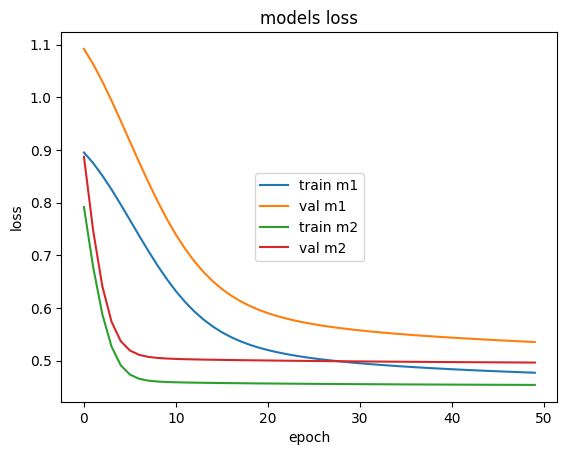

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('models loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train m1', 'val m1','train m2', 'val m2'], loc='center')

In [13]:
prediccion_val = []

def prediccion_fun(data,modelo, batch_size,scaler,dif=False,dif_cant=1, Series = None , n=1):
    prediccion = [0]* (len(data))
    i=0
    for X in data:
        X = np.reshape(X,(1,1,1))
        yhat = modelo1.predict(X, batch_size=batch_size,verbose=0)
        # invert scaling
        yhat = scaler.inverse_transform(yhat)
        if dif:
             # invert differencing
            yhat  = yhat + Series[(n+dif_cant*i)]
        # store
        prediccion[i]=yhat[0][0]
        i = i+1
    return prediccion
prediccion_test = prediccion_fun(super_gas_test_x_test,modelo1, 1,scaler,dif=True,dif_cant=1, Series = super_gas_df.values , n = len(super_gas_test_x_test))
prediccion_test_model_2 = prediccion_fun(super_gas_test_x_test,modelo2, 1,scaler,dif=True,dif_cant=1, Series = super_gas_df.values , n = len(super_gas_test_x_test))

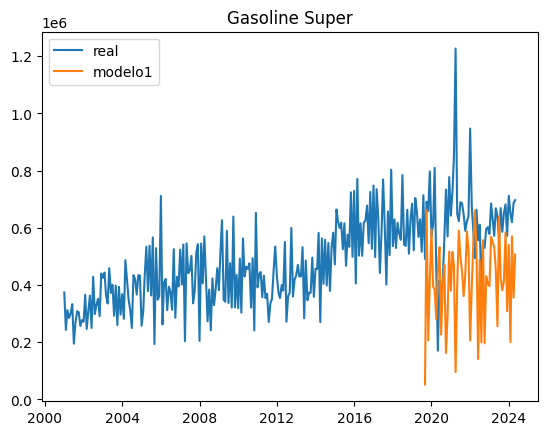

In [12]:

df_val = pd.DataFrame(prediccion_val,index=super_gas_df[(split_index):split_index+val_prueba].index)
df_test = pd.DataFrame(prediccion_test,index=super_gas_df[split_index + len(df_val):len(super_gas_df)].index)

# df_val2 = pd.DataFrame(prediccion_val_2,index=super_gas_df[(split_index):split_index+val_prueba].index)
# df_test_2 = pd.DataFrame(prediccion_test_model_2,index=super_gas_df[split_index + len(df_val):len(super_gas_df)].index)
plt.title('Gasoline Super')
plt.plot(super_gas_df)
plt.plot(df_test)
# plt.plot(df_test_2)
plt.legend(['real', 'modelo1'])

In [17]:
# se repite lo mismo para las demás series de los combustibles
losses = {}
dataframes = {}
for fueltype in ['GasolinaRegular', 'DieselLS' ,'DieselUltraLS', 'GasLicuado']:
    fueltype_df = importacion_df[['Fecha',fueltype]]
    fueltype_df = fueltype_df.dropna()
    fueltype_df = fueltype_df.set_index('Fecha')
    fueltype_diff = fueltype_df.diff()
    
    scaler = StandardScaler()
    fueltype_df_scaled = scaler.fit_transform(fueltype_diff)  # Drop NaN after diff
    
    split_index = round(0.6*len(fueltype_df_scaled))
    val_prueba = round(0.2*len(fueltype_df_scaled))
    
    fueltype_train = super_gas_scaled[1:split_index]
    fueltype_val = super_gas_scaled[split_index:val_prueba + split_index + 1]
    fueltype_test = super_gas_scaled[(split_index+val_prueba)-1:]

    fueltype_x_train,fueltype_y_train = supervisada(super_gas_train)
    fueltype_x_val,fueltype_y_val = supervisada(super_gas_val)
    fueltype_x_test,fueltype_y_test = supervisada(super_gas_test)
    
    #convertir en arreglos tridimensionales donde cada una es "muestras", "tiempo", "features"
    fueltype_x_train = np.reshape(fueltype_x_train,(fueltype_x_train.shape[0],1,1))
    fueltype_x_val = np.reshape(fueltype_x_val,(fueltype_x_val.shape[0],1,1))
    fueltype_x_test = np.reshape(fueltype_x_test, (fueltype_x_test.shape[0],1,1))

    lote = 1
    unidades =  1
    paso = 1
    caracteristicas = 1 #es univariada

    inputs = keras.layers.Input((paso,caracteristicas))
    lstm_out = keras.layers.LSTM(lote)(inputs)
    outputs = keras.layers.Dense(1)(lstm_out)

    fuelmodel1 = keras.Model(inputs=inputs, outputs=outputs)
    fuelmodel1.summary()
    fuelmodel1.compile(loss='mean_squared_error',optimizer="rmsprop")

    epocas = 50
    fuelhistory= fuelmodel1.fit(
        x = fueltype_x_train,
        y = fueltype_y_train,
        validation_data = (fueltype_x_val,fueltype_y_val),
        batch_size = lote,
        epochs = epocas,
        shuffle = False,
        verbose=1
    )
    losses[fueltype] = fuelhistory

    prediccion_val = []
    prediccion_val = prediccion_fun(fueltype_x_val,fuelmodel1, 1,scaler,dif=True,dif_cant=1, Series = fueltype_df.values , n=split_index)
    prediccion_test = prediccion_fun(fueltype_x_test,fuelmodel1, 1,scaler,dif=True,dif_cant=1, Series = fueltype_df.values , n=split_index+val_prueba)

    df_val = pd.DataFrame(prediccion_val,index=fueltype_df[(split_index):split_index+val_prueba].index)
    df_test = pd.DataFrame(prediccion_test,index=fueltype_df[split_index+len(df_val):len(fueltype_df)].index)

    dataframes[fueltype] = fueltype_df
    dataframes[fueltype+'_val'] = df_val
    dataframes[fueltype+'_test'] = df_test


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1, 1)]            0         
                                                                 
 lstm_7 (LSTM)               (None, 1)                 12        
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 14 (56.00 Byte)
Trainable params: 14 (56.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
166/166 [==============================] - 4s 6ms/step - loss: 0.9391 - val_loss: 1.1514
Epoch 2/50
166/166 [==============================] - 0s 3ms/step - loss: 0.9253 - val_loss: 1.1333
Epoch 3/50
166/166 [==============================] - 0s 3ms/step - loss: 0.9091 - val_lo

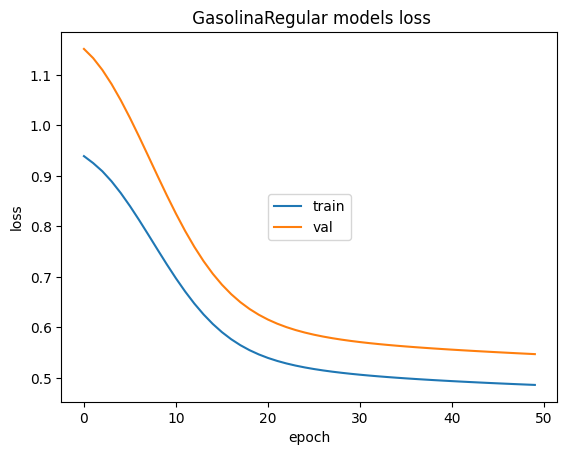

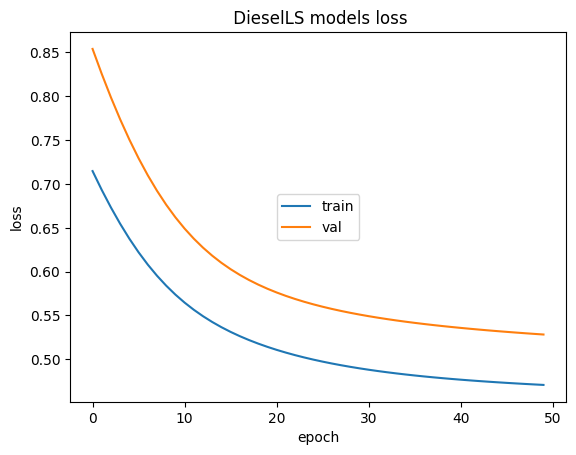

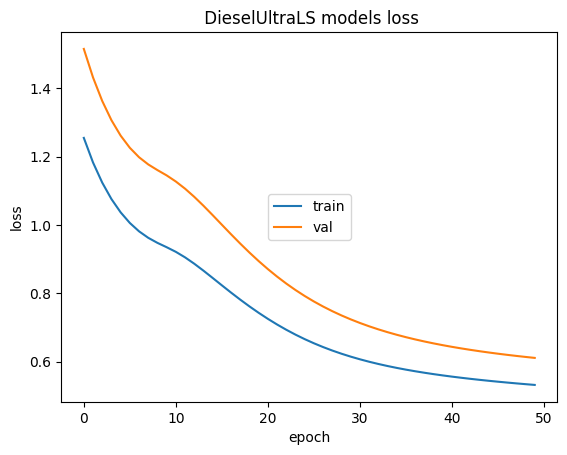

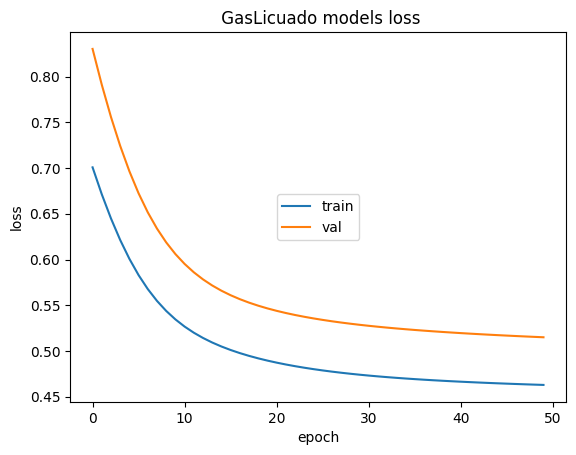

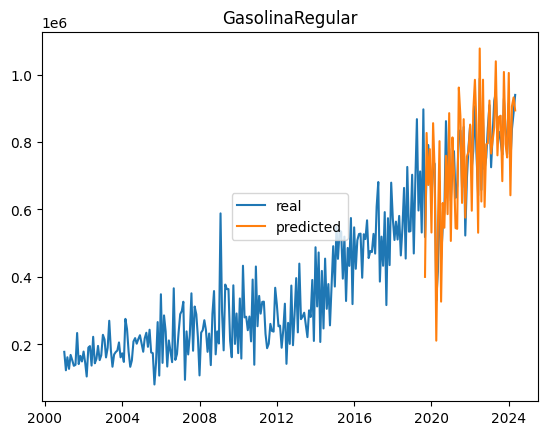

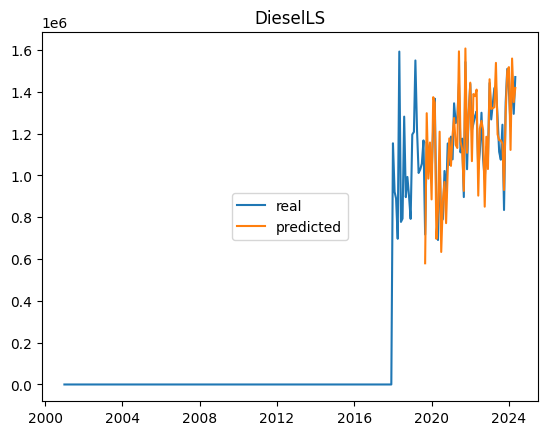

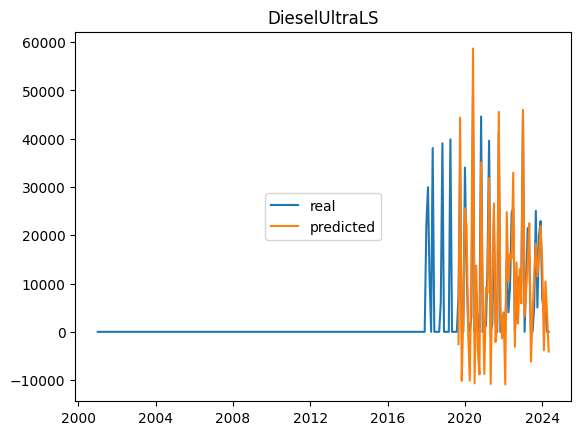

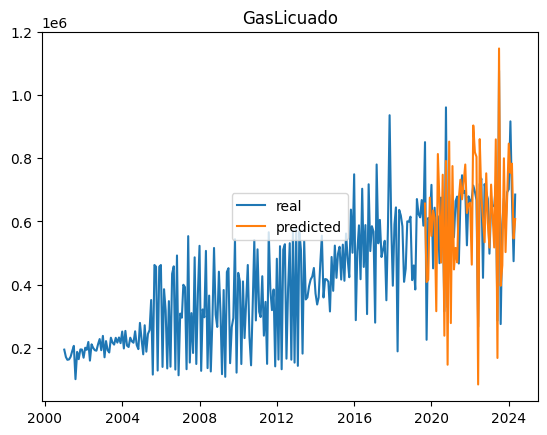

In [18]:
#plot all for each fuel type the loss and predicted values
for fueltype in ['GasolinaRegular', 'DieselLS' ,'DieselUltraLS', 'GasLicuado']:
    plt.plot(losses[fueltype].history['loss'])
    plt.plot(losses[fueltype].history['val_loss'])
    plt.title(f' {fueltype} models loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='center')
    plt.show()
    
for fueltype in ['GasolinaRegular', 'DieselLS' ,'DieselUltraLS', 'GasLicuado']:
    plt.title(fueltype)
    plt.plot(dataframes[fueltype])
    plt.plot(dataframes[fueltype +'_test'])
    plt.legend(['real', 'predicted'], loc='center')
    plt.show()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5613
Epoch 2/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3908
Epoch 3/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3906
Epoch 4/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3912
Epoch 5/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3917
Epoch 6/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3919
Epoch 7/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3921
Epoch 8/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3922
Epoch 9/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3923
Epoch 10/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3923
Epoch 11/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3923
Epoch 12/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3923
Epoch 13/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3923
Epoch 14/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3924
Epoch 15/100
238/238 ━━━━━━━━━━━━━━━━━━━━ 0

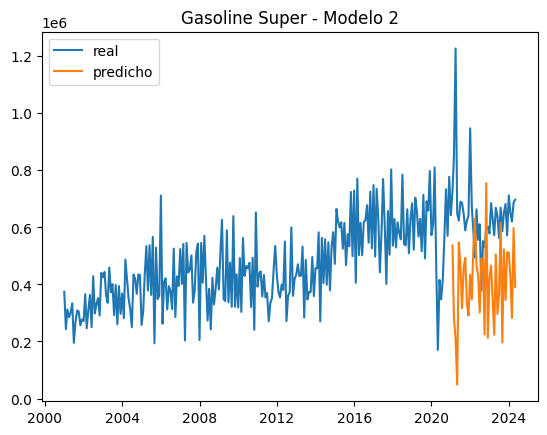

In [13]:
# Configuración del segundo modelo LSTM
unidades_2 = 50  # Aumentar el número de neuronas
paso_2 = 1
caracteristicas_2 = 1

inputs_2 = keras.layers.Input((paso_2, caracteristicas_2))
lstm_out_2 = keras.layers.LSTM(unidades_2, return_sequences=True)(inputs_2)
lstm_out_2 = keras.layers.LSTM(unidades_2)(lstm_out_2)
outputs_2 = keras.layers.Dense(1)(lstm_out_2)

modelo2 = keras.Model(inputs=inputs_2, outputs=outputs_2)
modelo2.summary()
modelo2.compile(loss='mean_squared_error', optimizer="adam")

epocas_2 = 100  # Aumentar el número de épocas
history_2 = modelo2.fit(
    x=super_gas_x_train,
    y=super_gas_y_train,
    batch_size=lote,
    epochs=epocas_2,
    shuffle=False,
    verbose=1
)

# Predicción con el segundo modelo
prediccion_test_2 = prediccion_fun(super_gas_test_x_test, modelo2, 1, scaler, dif=True, dif_cant=1, Series=super_gas_df.values, n=len(super_gas_test_x_test))

# Graficar los resultados del segundo modelo
df_test_2 = pd.DataFrame(prediccion_test_2, index=super_gas_df[split_index + 1:len(super_gas_df)].index)
plt.title('Gasoline Super - Modelo 2')
plt.plot(super_gas_df)
plt.plot(df_test_2)
plt.legend(['real', 'predicho'])
plt.show()


In [3]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
# Cargar el archivo de importación
importacion_df = pd.read_excel('importacion.xlsx', skiprows=6)

# Definir los nombres de las columnas
importacion_df.columns = [
    'Fecha', 'AceitesLubricantes', 'Asfalto', 'Bunker', 'Ceras', 
    'CombustibleTurboJet', 'DieselLS', 'DieselUltraLS', 'GasLicuado', 
    'GasolinaAviacion', 'GasolinaRegular', 'GasolinaSuper', 'Kerosina', 
    'MTBE', 'Naftas', 'Petcoke', 'PetroleoCrudo', 'Solventes', 
    'Butano', 'DieselAltoAzufre', 'Orimulsion', 'PetroleoReconstituido', 
    'TotalImportacion', 'ColumnaExtra1', 'ColumnaExtra2'
]

# Convertir la columna de fechas a formato datetime
importacion_df['Fecha'] = pd.to_datetime(importacion_df['Fecha'], errors='coerce')
importacion_df = importacion_df.dropna()

# Filtrar solo las columnas de interés
importacion_df = importacion_df[['Fecha','GasolinaRegular', 'GasolinaSuper', 'DieselLS' ,'DieselUltraLS', 'GasLicuado']]


In [7]:
def supervisada(serie, retrasos=1):
    serie_x = []
    serie_y = []
    for i in range(len(serie) - retrasos):
        valor = serie[i:(i + retrasos)]
        valor_sig = serie[i + retrasos]
        serie_x.append(valor)
        serie_y.append(valor_sig)
    return np.array(serie_x), np.array(serie_y)


In [9]:
lote = 1  # Tamaño de lote (batch size)


In [5]:
# Definir la fecha de división (puedes ajustar esta fecha según tus datos)
split_date = '2021-01-01'

# Calcular el índice correspondiente a la fecha de división
split_index = importacion_df[importacion_df['Fecha'] == split_date].index.tolist()[0]

# Asegúrate de que la variable `split_index` esté definida antes de usarla
print(f"El índice de división es: {split_index}")


El índice de división es: 240


In [16]:
def prediccion_fun(data, modelo, batch_size, scaler, dif=False, dif_cant=1, Series=None, n=1):
    prediccion = []
    for i, X in enumerate(data):
        X = np.reshape(X, (1, 1, 1))
        yhat = modelo.predict(X, batch_size=batch_size, verbose=0)
        yhat = scaler.inverse_transform(yhat)
        if dif:
            yhat = yhat + Series[split_index + i + 1]  # Invertir la diferenciación sumando al valor previo
        prediccion.append(yhat[0][0])
    return prediccion


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.3579
Epoch 2/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3170
Epoch 3/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3176
Epoch 4/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3180
Epoch 5/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182
Epoch 6/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182
Epoch 7/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182
Epoch 8/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182
Epoch 9/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182
Epoch 10/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3182
Epoch 11/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182
Epoch 12/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3182
Epoch 13/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3182
Epoch 14/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3182
Epoch 15/60
238/238 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - lo

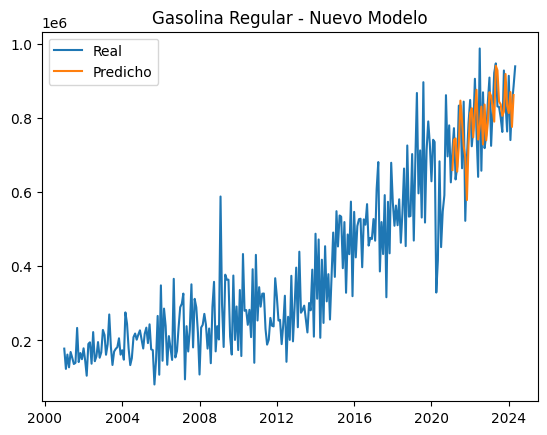

In [17]:
# Predicción de la gasolina regular
regular_gas_df = importacion_df[['Fecha','GasolinaRegular']]
regular_gas_df = regular_gas_df.set_index('Fecha')

# Diferenciación y normalización
regular_gas_diff = regular_gas_df.diff()
scaler_regular = StandardScaler()
regular_gas_scaled = scaler_regular.fit_transform(regular_gas_diff.dropna())

# Separar en train y test
regular_gas_train = regular_gas_scaled[1:split_index]
regular_gas_test = regular_gas_scaled[split_index:]

# Transformar en serie supervisada
regular_gas_x_train, regular_gas_y_train = supervisada(regular_gas_train)
regular_gas_x_test, regular_gas_y_test = supervisada(regular_gas_test)

# Convertir a arreglos tridimensionales
regular_gas_x_train = np.reshape(regular_gas_x_train, (regular_gas_x_train.shape[0], 1, 1))
regular_gas_x_test = np.reshape(regular_gas_x_test, (regular_gas_x_test.shape[0], 1, 1))

# Nuevo modelo LSTM
unidades_reg = 100  # Aumentar el número de neuronas
paso_reg = 1
caracteristicas_reg = 1

inputs_reg = keras.layers.Input((paso_reg, caracteristicas_reg))
lstm_out_reg = keras.layers.LSTM(unidades_reg, return_sequences=True)(inputs_reg)
lstm_out_reg = keras.layers.LSTM(unidades_reg)(lstm_out_reg)
outputs_reg = keras.layers.Dense(1)(lstm_out_reg)

modelo_regular = keras.Model(inputs=inputs_reg, outputs=outputs_reg)
modelo_regular.summary()
modelo_regular.compile(loss='mean_squared_error', optimizer="adam")

epocas_reg = 60  # Ajustar el número de épocas
history_regular = modelo_regular.fit(
    x=regular_gas_x_train,
    y=regular_gas_y_train,
    batch_size=lote,
    epochs=epocas_reg,
    shuffle=False,
    verbose=1
)

# Predicción con el nuevo modelo
prediccion_test_regular = prediccion_fun(regular_gas_x_test, modelo_regular, 1, scaler_regular, dif=True, dif_cant=1, Series=regular_gas_df.values, n=len(regular_gas_x_test))

# Ajustar el índice del DataFrame para que coincida con el número de predicciones
indices = regular_gas_df[split_index + 1:split_index + 1 + len(prediccion_test_regular)].index

# Crear el DataFrame con los índices ajustados
df_test_regular = pd.DataFrame(prediccion_test_regular, index=indices)

# Graficar los resultados del nuevo modelo
plt.title('Gasolina Regular - Nuevo Modelo')
plt.plot(regular_gas_df, label='Real')
plt.plot(df_test_regular, label='Predicho')
plt.legend()
plt.show()


Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.2777
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2362
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2368
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2374
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2378
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2380
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2381
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 9/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 10/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 11/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 12/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 13/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 14/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 15/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

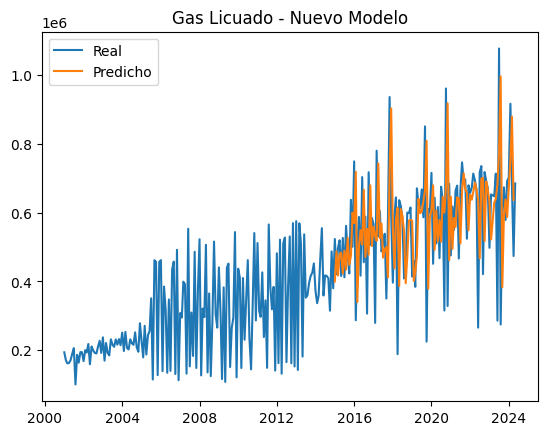

In [19]:
# Predicción para Gas Licuado
gas_licuado_df = importacion_df[['Fecha','GasLicuado']]
gas_licuado_df = gas_licuado_df.set_index('Fecha')

# Diferenciación y normalización
gas_licuado_diff = gas_licuado_df.diff()
scaler_gas_licuado = StandardScaler()
gas_licuado_scaled = scaler_gas_licuado.fit_transform(gas_licuado_diff.dropna())

# Separar en train y test
gas_licuado_train = gas_licuado_scaled[1:split_index]
gas_licuado_test = gas_licuado_scaled[split_index:]

# Transformar en serie supervisada
gas_licuado_x_train, gas_licuado_y_train = supervisada(gas_licuado_train)
gas_licuado_x_test, gas_licuado_y_test = supervisada(gas_licuado_test)

# Convertir a arreglos tridimensionales
gas_licuado_x_train = np.reshape(gas_licuado_x_train, (gas_licuado_x_train.shape[0], 1, 1))
gas_licuado_x_test = np.reshape(gas_licuado_x_test, (gas_licuado_x_test.shape[0], 1, 1))

# Nuevo modelo LSTM
unidades_gas_licuado = 100  # Aumentar el número de neuronas
paso_gas_licuado = 1
caracteristicas_gas_licuado = 1

inputs_gas_licuado = keras.layers.Input((paso_gas_licuado, caracteristicas_gas_licuado))
lstm_out_gas_licuado = keras.layers.LSTM(unidades_gas_licuado, return_sequences=True)(inputs_gas_licuado)
lstm_out_gas_licuado = keras.layers.LSTM(unidades_gas_licuado)(lstm_out_gas_licuado)
outputs_gas_licuado = keras.layers.Dense(1)(lstm_out_gas_licuado)

modelo_gas_licuado = keras.Model(inputs=inputs_gas_licuado, outputs=outputs_gas_licuado)
modelo_gas_licuado.summary()
modelo_gas_licuado.compile(loss='mean_squared_error', optimizer="adam")

epocas_gas_licuado = 60  # Ajustar el número de épocas
history_gas_licuado = modelo_gas_licuado.fit(
    x=gas_licuado_x_train,
    y=gas_licuado_y_train,
    batch_size=lote,
    epochs=epocas_gas_licuado,
    shuffle=False,
    verbose=1
)

# Predicción con el nuevo modelo
prediccion_test_gas_licuado = prediccion_fun(gas_licuado_x_test, modelo_gas_licuado, 1, scaler_gas_licuado, dif=True, dif_cant=1, Series=gas_licuado_df.values, n=len(gas_licuado_x_test))

# Ajustar el índice del DataFrame para que coincida con el número de predicciones
indices_gas_licuado = gas_licuado_df[split_index + 1:split_index + 1 + len(prediccion_test_gas_licuado)].index

# Crear el DataFrame con los índices ajustados
df_test_gas_licuado = pd.DataFrame(prediccion_test_gas_licuado, index=indices_gas_licuado)

# Graficar los resultados del nuevo modelo
plt.title('Gas Licuado - Nuevo Modelo')
plt.plot(gas_licuado_df, label='Real')
plt.plot(df_test_gas_licuado, label='Predicho')
plt.legend()
plt.show()


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_14 (LSTM)                  │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.0754e-04
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.5850e-12
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 9/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 10/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0000e+00
Epoch 11/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 12/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 13/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
Epoch 14/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0000e+00
E

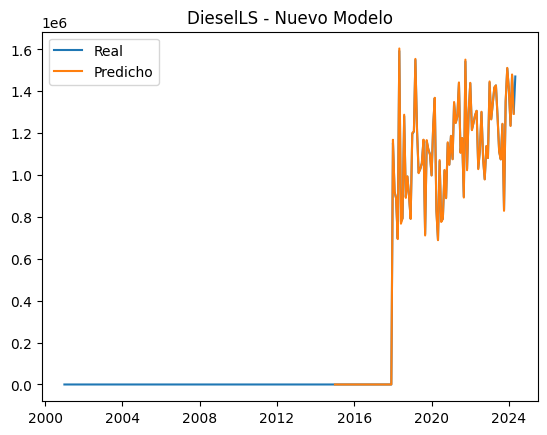

In [20]:
# Predicción para DieselLS
diesel_ls_df = importacion_df[['Fecha','DieselLS']]
diesel_ls_df = diesel_ls_df.set_index('Fecha')

# Diferenciación y normalización
diesel_ls_diff = diesel_ls_df.diff()
scaler_diesel_ls = StandardScaler()
diesel_ls_scaled = scaler_diesel_ls.fit_transform(diesel_ls_diff.dropna())

# Separar en train y test
diesel_ls_train = diesel_ls_scaled[1:split_index]
diesel_ls_test = diesel_ls_scaled[split_index:]

# Transformar en serie supervisada
diesel_ls_x_train, diesel_ls_y_train = supervisada(diesel_ls_train)
diesel_ls_x_test, diesel_ls_y_test = supervisada(diesel_ls_test)

# Convertir a arreglos tridimensionales
diesel_ls_x_train = np.reshape(diesel_ls_x_train, (diesel_ls_x_train.shape[0], 1, 1))
diesel_ls_x_test = np.reshape(diesel_ls_x_test, (diesel_ls_x_test.shape[0], 1, 1))

# Nuevo modelo LSTM
unidades_diesel_ls = 100  # Aumentar el número de neuronas
paso_diesel_ls = 1
caracteristicas_diesel_ls = 1

inputs_diesel_ls = keras.layers.Input((paso_diesel_ls, caracteristicas_diesel_ls))
lstm_out_diesel_ls = keras.layers.LSTM(unidades_diesel_ls, return_sequences=True)(inputs_diesel_ls)
lstm_out_diesel_ls = keras.layers.LSTM(unidades_diesel_ls)(lstm_out_diesel_ls)
outputs_diesel_ls = keras.layers.Dense(1)(lstm_out_diesel_ls)

modelo_diesel_ls = keras.Model(inputs=inputs_diesel_ls, outputs=outputs_diesel_ls)
modelo_diesel_ls.summary()
modelo_diesel_ls.compile(loss='mean_squared_error', optimizer="adam")

epocas_diesel_ls = 60  # Ajustar el número de épocas
history_diesel_ls = modelo_diesel_ls.fit(
    x=diesel_ls_x_train,
    y=diesel_ls_y_train,
    batch_size=lote,
    epochs=epocas_diesel_ls,
    shuffle=False,
    verbose=1
)

# Predicción con el nuevo modelo
prediccion_test_diesel_ls = prediccion_fun(diesel_ls_x_test, modelo_diesel_ls, 1, scaler_diesel_ls, dif=True, dif_cant=1, Series=diesel_ls_df.values, n=len(diesel_ls_x_test))

# Ajustar el índice del DataFrame para que coincida con el número de predicciones
indices_diesel_ls = diesel_ls_df[split_index + 1:split_index + 1 + len(prediccion_test_diesel_ls)].index

# Crear el DataFrame con los índices ajustados
df_test_diesel_ls = pd.DataFrame(prediccion_test_diesel_ls, index=indices_diesel_ls)

# Graficar los resultados del nuevo modelo
plt.title('DieselLS - Nuevo Modelo')
plt.plot(diesel_ls_df, label='Real')
plt.plot(df_test_diesel_ls, label='Predicho')
plt.legend()
plt.show()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2805
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2363
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2367
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2373
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2377
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2379
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2380
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 9/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 10/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 11/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 12/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 13/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 14/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2381
Epoch 15/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - lo

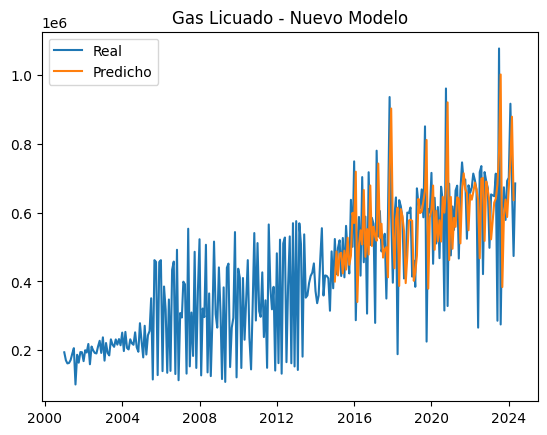

In [21]:
# Predicción para Gas Licuado
gas_licuado_df = importacion_df[['Fecha','GasLicuado']]
gas_licuado_df = gas_licuado_df.set_index('Fecha')

# Diferenciación y normalización
gas_licuado_diff = gas_licuado_df.diff()
scaler_gas_licuado = StandardScaler()
gas_licuado_scaled = scaler_gas_licuado.fit_transform(gas_licuado_diff.dropna())

# Separar en train y test
split_index = round(0.6 * len(gas_licuado_scaled))  # Asegúrate de definir split_index para Gas Licuado
gas_licuado_train = gas_licuado_scaled[1:split_index]
gas_licuado_test = gas_licuado_scaled[split_index:]

# Transformar en serie supervisada
gas_licuado_x_train, gas_licuado_y_train = supervisada(gas_licuado_train)
gas_licuado_x_test, gas_licuado_y_test = supervisada(gas_licuado_test)

# Convertir a arreglos tridimensionales
gas_licuado_x_train = np.reshape(gas_licuado_x_train, (gas_licuado_x_train.shape[0], 1, 1))
gas_licuado_x_test = np.reshape(gas_licuado_x_test, (gas_licuado_x_test.shape[0], 1, 1))

# Nuevo modelo LSTM
unidades_gas_licuado = 100  # Aumentar el número de neuronas
paso_gas_licuado = 1
caracteristicas_gas_licuado = 1

inputs_gas_licuado = keras.layers.Input((paso_gas_licuado, caracteristicas_gas_licuado))
lstm_out_gas_licuado = keras.layers.LSTM(unidades_gas_licuado, return_sequences=True)(inputs_gas_licuado)
lstm_out_gas_licuado = keras.layers.LSTM(unidades_gas_licuado)(lstm_out_gas_licuado)
outputs_gas_licuado = keras.layers.Dense(1)(lstm_out_gas_licuado)

modelo_gas_licuado = keras.Model(inputs=inputs_gas_licuado, outputs=outputs_gas_licuado)
modelo_gas_licuado.summary()
modelo_gas_licuado.compile(loss='mean_squared_error', optimizer="adam")

epocas_gas_licuado = 60  # Ajustar el número de épocas
history_gas_licuado = modelo_gas_licuado.fit(
    x=gas_licuado_x_train,
    y=gas_licuado_y_train,
    batch_size=lote,
    epochs=epocas_gas_licuado,
    shuffle=False,
    verbose=1
)

# Predicción con el nuevo modelo
prediccion_test_gas_licuado = prediccion_fun(gas_licuado_x_test, modelo_gas_licuado, 1, scaler_gas_licuado, dif=True, dif_cant=1, Series=gas_licuado_df.values, n=len(gas_licuado_x_test))

# Ajustar el índice del DataFrame para que coincida con el número de predicciones
indices_gas_licuado = gas_licuado_df[split_index + 1:split_index + 1 + len(prediccion_test_gas_licuado)].index

# Crear el DataFrame con los índices ajustados
df_test_gas_licuado = pd.DataFrame(prediccion_test_gas_licuado, index=indices_gas_licuado)

# Graficar los resultados del nuevo modelo
plt.title('Gas Licuado - Nuevo Modelo')
plt.plot(gas_licuado_df, label='Real')
plt.plot(df_test_gas_licuado, label='Predicho')
plt.legend()
plt.show()


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 1, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 1, 100)         │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,301 (473.83 KB)

 Trainable params: 121,301 (473.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.2089e-07
Epoch 2/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.7831e-14
Epoch 3/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.8039e-21
Epoch 4/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7.5652e-22
Epoch 5/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0187e-21
Epoch 6/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.0543e-08
Epoch 7/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0851e-12
Epoch 8/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.9205e-20
Epoch 9/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.8745e-08
Epoch 10/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6376e-13
Epoch 11/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.0972e-20
Epoch 12/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.6894e-08
Epoch 13/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5.6115e-12
Epoch 14/60
165/165 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.3959e-19
E

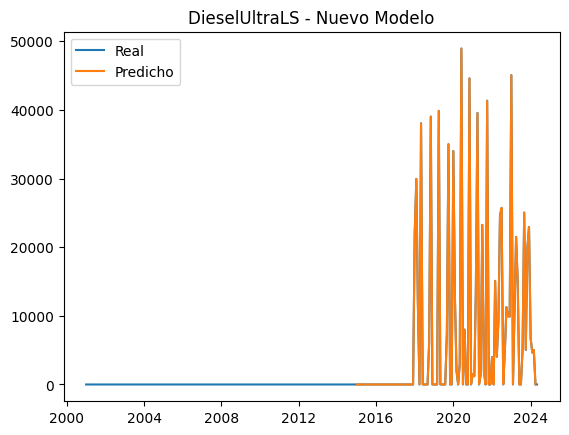

In [22]:
# Predicción para DieselUltraLS
diesel_ultra_ls_df = importacion_df[['Fecha','DieselUltraLS']]
diesel_ultra_ls_df = diesel_ultra_ls_df.set_index('Fecha')

# Diferenciación y normalización
diesel_ultra_ls_diff = diesel_ultra_ls_df.diff()
scaler_diesel_ultra_ls = StandardScaler()
diesel_ultra_ls_scaled = scaler_diesel_ultra_ls.fit_transform(diesel_ultra_ls_diff.dropna())


split_index = round(0.6 * len(diesel_ultra_ls_scaled))  # Asegúrate de definir split_index para DieselUltraLS
diesel_ultra_ls_train = diesel_ultra_ls_scaled[1:split_index]
diesel_ultra_ls_test = diesel_ultra_ls_scaled[split_index:]

# Transformar en serie supervisada
diesel_ultra_ls_x_train, diesel_ultra_ls_y_train = supervisada(diesel_ultra_ls_train)
diesel_ultra_ls_x_test, diesel_ultra_ls_y_test = supervisada(diesel_ultra_ls_test)

diesel_ultra_ls_x_train = np.reshape(diesel_ultra_ls_x_train, (diesel_ultra_ls_x_train.shape[0], 1, 1))
diesel_ultra_ls_x_test = np.reshape(diesel_ultra_ls_x_test, (diesel_ultra_ls_x_test.shape[0], 1, 1))

unidades_diesel_ultra_ls = 100  # Aumentar el número de neuronas
paso_diesel_ultra_ls = 1
caracteristicas_diesel_ultra_ls = 1

inputs_diesel_ultra_ls = keras.layers.Input((paso_diesel_ultra_ls, caracteristicas_diesel_ultra_ls))
lstm_out_diesel_ultra_ls = keras.layers.LSTM(unidades_diesel_ultra_ls, return_sequences=True)(inputs_diesel_ultra_ls)
lstm_out_diesel_ultra_ls = keras.layers.LSTM(unidades_diesel_ultra_ls)(lstm_out_diesel_ultra_ls)
outputs_diesel_ultra_ls = keras.layers.Dense(1)(lstm_out_diesel_ultra_ls)

modelo_diesel_ultra_ls = keras.Model(inputs=inputs_diesel_ultra_ls, outputs=outputs_diesel_ultra_ls)
modelo_diesel_ultra_ls.summary()
modelo_diesel_ultra_ls.compile(loss='mean_squared_error', optimizer="adam")

epocas_diesel_ultra_ls = 60  
history_diesel_ultra_ls = modelo_diesel_ultra_ls.fit(
    x=diesel_ultra_ls_x_train,
    y=diesel_ultra_ls_y_train,
    batch_size=lote,
    epochs=epocas_diesel_ultra_ls,
    shuffle=False,
    verbose=1
)


prediccion_test_diesel_ultra_ls = prediccion_fun(diesel_ultra_ls_x_test, modelo_diesel_ultra_ls, 1, scaler_diesel_ultra_ls, dif=True, dif_cant=1, Series=diesel_ultra_ls_df.values, n=len(diesel_ultra_ls_x_test))


indices_diesel_ultra_ls = diesel_ultra_ls_df[split_index + 1:split_index + 1 + len(prediccion_test_diesel_ultra_ls)].index


df_test_diesel_ultra_ls = pd.DataFrame(prediccion_test_diesel_ultra_ls, index=indices_diesel_ultra_ls)


plt.title('DieselUltraLS - Nuevo Modelo')
plt.plot(diesel_ultra_ls_df, label='Real')
plt.plot(df_test_diesel_ultra_ls, label='Predicho')
plt.legend()
plt.show()


DieselUltraLS: En los gráficos proporcionados, se observan las predicciones realizadas por dos modelos LSTM diferentes para la serie temporal "DieselUltraLS". El primer modelo muestra una mayor variabilidad y un patrón de predicción errático, donde las predicciones tienen picos abruptos y desajustes considerables respecto a los valores reales. Por otro lado, el segundo modelo muestra un ajuste más coherente con los datos reales, aunque todavía hay variaciones significativas. Sin embargo, a diferencia del primer modelo, el segundo logra capturar mejor las tendencias generales y la forma de los datos reales. Este comportamiento indice que el segundo modelo tiene un mejor desempeño, ya que a pesar de no ser perfecto, sigue más de cerca la evolución de los datos históricos, minimizando los errores extremos observados en el primer modelo.